In [1]:
import cv2  # For image processing
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    labels = []

    for label_folder in os.listdir(folder):
        # Skip hidden files and folders like .DS_Store
        if label_folder.startswith('.'):
            continue

        label_path = os.path.join(folder, label_folder)
        # Check if it's actually a directory
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    if label_folder == 'NORMAL':
                        labels.append(0)
                    else:
                        labels.append(1)

    return np.array(images), np.array(labels)

def flatten_images(images):
    n_samples = images.shape[0]
    return images.reshape((n_samples, -1))  # Flatten each image

In [4]:
train = '/content/drive/MyDrive/CS464 project/chest_xray/train'
val =  '/content/drive/MyDrive/CS464 project/chest_xray/val'
test = '/content/drive/MyDrive/CS464 project/chest_xray/test'

train_X, train_Y =load_images_from_folder(train, img_size=(128, 128))
val_X, val_Y =load_images_from_folder(val, img_size=(128, 128))
test_X, test_Y =load_images_from_folder(test, img_size=(128, 128))

train_X = flatten_images(train_X)
val_X = flatten_images(val_X)
test_X = flatten_images(test_X)

In [5]:
train_X = np.concatenate((val_X, train_X), axis=0)
train_Y = np.concatenate((val_Y, train_Y), axis=0)

In [6]:
train_X = train_X.reshape(-1, 128, 128, 1)/255.0
test_X = test_X.reshape(-1, 128, 128, 1)/255.0

In [7]:
model = Sequential([
    # Convolutional layers
    (Conv2D(128, (3, 3), activation=None, input_shape=(128, 128, 1))),
    (LeakyReLU(alpha=0.1)),
    (MaxPooling2D(pool_size=(2, 2))),

    (Conv2D(128, (5, 5), activation=None)),
    (LeakyReLU(alpha=0.1)),
    (MaxPooling2D(pool_size=(2, 2))),

    (Conv2D(64, (5, 5), activation=None)),
    (LeakyReLU(alpha=0.1)),
    (MaxPooling2D(pool_size=(2, 2))),

    (Conv2D(32, (5, 5), activation=None)),
    (LeakyReLU(alpha=0.1)),
    (MaxPooling2D(pool_size=(2, 2))),

    # Flatten
    (Flatten()),

    # Dense layer
    (Dense(64, activation='relu')),
    (Dropout(0.4)),

    # Output layer
    (Dense(1, activation='sigmoid'))
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Model Summary
model.summary()

checkpoint = ModelCheckpoint("model.keras", monitor='val_accuracy', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
# Training

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 126, 126, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 59, 59, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 59, 59, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 700,001 (2.67 MB)

 Trainable params: 700,001 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_X, train_Y,
    validation_split = 0.2,
    epochs=100,
    batch_size=58,
    callbacks=[checkpoint, early, reduce_lr],
    verbose=1
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8832 - loss: 0.3635
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8836 - loss: 0.3629 - val_accuracy: 0.0000e+00 - val_loss: 3.2558 - learning_rate: 0.0010
Epoch 2/100
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9157 - loss: 0.2964
Epoch 2: val_accuracy did not improve from 0.00000
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9159 - loss: 0.2954 - val_accuracy: 0.0000e+00 - val_loss: 2.4872 - learning_rate: 0.0010
Epoch 3/100
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9230 - loss: 0.2192
Epoch 3: val_accuracy improved from 0.00000 to 0.06691, saving model to model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9230 - loss: 0.2192 - val_accuracy: 0.0669 - val_loss: 1.3101 - learning_rate: 0.0010
Epoch 4/100
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9296 - loss: 0.1991
Epoch 4: va

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


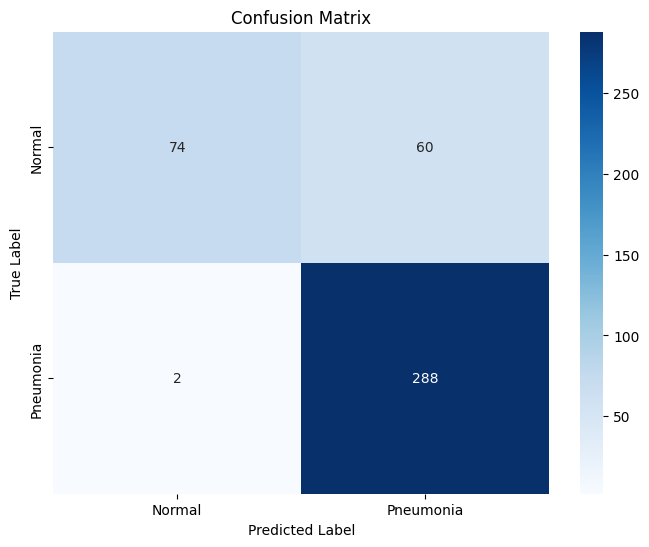

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_X)
y_pred_classes = (y_pred > 0.5).astype("int32")

conf_matrix = confusion_matrix(test_Y, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# precision
precision = precision_score(test_Y, y_pred_classes)
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(test_Y, y_pred_classes)
print(f"Recall: {recall:.4f}")

# F1 score
f1 = f1_score(test_Y, y_pred_classes)
print(f"F1 Score: {f1:.4f}")

# accuracy
accuracy = accuracy_score(test_Y, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8276
Recall: 0.9931
F1 Score: 0.9028
Accuracy: 0.8538
